In [ ]:
!pip install pm4py
!pip install shap

     |████████████████████████████████| 1.8 MB 8.8 MB/s 
  Created wheel for stringdist: filename=StringDist-1.0.9-cp37-cp37m-linux_x86_64.whl size=23589 sha256=60eb1e6d06593401d5ef4ad708913fa003426359d7f19133ac9c3ae99c0dc5e3
  Stored in directory: /root/.cache/pip/wheels/d7/9c/d4/63bc3d8931de0980b9e4a724dea290bb40b8b1b2bd6227c8da
Successfully built stringdist
     |████████████████████████████████| 564 kB 9.0 MB/s 


In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 205 µs (started: 2022-03-24 10:52:30 +00:00)


In [ ]:
#!wget https://raw.githubusercontent.com/pm4py/pm4py-ws/master/files/event_logs/receipt.xes

time: 1.53 ms (started: 2022-03-24 10:52:30 +00:00)


In [ ]:
from typing import *
import pandas as pd
import numpy as np
import pickle
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.obj import Trace
from pm4py.util import pandas_utils
from pm4py.objects.conversion.log import converter as conversion_factory
from pm4py.visualization.petri_net import visualizer as pn_vis
from pm4py.util import constants
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.util import exec_utils
from pm4py.statistics.variants.log import get as variants_get
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.filtering.log.start_activities import start_activities_filter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.filtering.log.end_activities import end_activities_filter
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.filtering.log.cases import case_filter
from pm4py.objects.log.obj import EventLog, EventStream
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from sklearn.tree import DecisionTreeClassifier
from pm4py.visualization.decisiontree import visualizer as dt_visualizer

time: 1.47 s (started: 2022-03-24 10:52:30 +00:00)


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, accuracy_score
import xgboost as xgb
from xgboost import cv
from sklearn.model_selection import cross_validate
import pickle
from sklearn.model_selection import GridSearchCV
import shap
import math 
import tensorflow as tf
from statistics import median

time: 4.84 s (started: 2022-03-24 10:52:31 +00:00)


In [ ]:
log = pm4py.read_xes("final_roadtraffic.xes")
target = pd.read_pickle("/content/target_roadtraffic.pkl")

parsing log, completed traces ::   0%|          | 0/24641 [00:00<?, ?it/s]

time: 30.5 s (started: 2022-03-24 10:52:36 +00:00)


In [ ]:
trace_cnt = 0
trace_len = 0
for trace in log:
  trace_len += len(trace)
  trace_cnt += 1

time: 30.9 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
trace_len/trace_cnt

5.344507122275882

time: 2.88 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
attributes_filter.get_attribute_values(log, "concept:name").keys()

dict_keys(['Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Insert Date Appeal to Prefecture', 'Send Appeal to Prefecture', 'Receive Result Appeal from Prefecture', 'Notify Result Appeal to Offender', 'Appeal to Judge', 'Send for Credit Collection'])

time: 214 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
print(len(list(attributes_filter.get_attribute_values(log, "concept:name").keys())))

11
time: 187 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
def get_col_name(event_E_concept_name:str,event_F_concept_name:str, relation_name:str)->str:
    tuple_event = (event_E_concept_name,event_F_concept_name)
    relation_name = relation_name
    str_return = str(tuple_event)+'_'+relation_name
    return str_return 
    

time: 2.48 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
def generate_ordered_matters_columns(log:EventLog, relation_name:str)->list:
    activities = attributes_filter.get_attribute_values(log, "concept:name").keys()
    
    log_start = start_activities_filter.get_start_activities(log)
    end_activities = end_activities_filter.get_end_activities(log)
    list_respon = set()
  
    for item_e in activities:
      for item_f in activities:
        #if item_e not in log_start.keys():
        if item_e != item_f:
          col_name = get_col_name(item_e,item_f, relation_name)
          list_respon.add(col_name)
            
    return list(list_respon)

time: 10.9 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
def generate_ordered_doesnt_matters_columns(log:EventLog, relation_name:str)->list:
    activities = attributes_filter.get_attribute_values(log, "concept:name").keys()
    
    log_start = start_activities_filter.get_start_activities(log)
    end_activities = end_activities_filter.get_end_activities(log)
    list_respon = set()
    
    for item_e in activities:
        for item_f in activities:
            if item_e != item_f:
                item_e_sort, item_f_sort = tuple(sorted((item_e,item_f)))
                col_name = get_col_name(item_e_sort,item_f_sort, relation_name)
                list_respon.add(col_name)
    return list(list_respon)

time: 10.4 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
def log_len(log:EventLog)->int:
    cases = 0
    for trace in log:
        cases+=1
    return cases

time: 3.03 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
# Event F is a response of event E
# naming convention ex: (A,B)_response ==> B came after A
# actecedent : event[0]
# consequent : event[1]
def response(log:EventLog)->pd.DataFrame:
    relation_name = 'response'
    feature_list = generate_ordered_matters_columns(log,relation_name)
    total_traces = log_len(log)
    response_df = pd.DataFrame(0, index=np.arange(total_traces), columns=feature_list)
    for trace_idx, trace in enumerate(log):
        for event_E_idx, event_E in enumerate(trace[1:-1]):
            event_E_idx= event_E_idx + 2
            for event_F in trace[event_E_idx:-1]:
                if event_E['concept:name']!=event_F['concept:name']:
                    col_name = get_col_name(event_E['concept:name'], event_F['concept:name'],relation_name)
                    col_idx = feature_list.index(col_name)
                    response_df.iloc[trace_idx,col_idx]+=1
    return response_df

time: 15.8 ms (started: 2022-03-24 10:53:07 +00:00)


**New response Approach**


*   the trace is split based on the activtyy. foe each split we check what are the common following activities in the response list.
*   example: <a,b,c,d,a,b,c>

>  There is a response replation between 

* splits produced when event_e = "a" are <b,c,d>,<b,c>
(a,b),(a,c) as every time "a" occurs "b" and "c" follows

* activty "c" will not have aresponse relation with any other activity :
splits produced when event_e = "c" are <d,a,b>,<None> 




In [ ]:
def trace_to_string(trace:Trace)-> Tuple[set, str]:
  unique_events = set()
  str_trace = ""
  last_event = ""
  for event in trace:
    if event["concept:name"] != last_event:
      str_trace += event['concept:name'] +","
    last_event = event['concept:name']
    unique_events.add(event['concept:name']+",")
  return (unique_events,str_trace)

time: 5.64 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
def common_event_in_following(list_followings:list)->list:
  intersection_set = set()
  first_set = True
  for following_events in list_followings :
    if first_set:
      all_following_events = following_events.split(",")[:-1]
      intersection_set = set(all_following_events)
      first_set = False
    else:
      all_following_events = set(following_events.split(",")[:-1])
      intersection_set = intersection_set.intersection(all_following_events)
      
  return list(intersection_set)





time: 16.2 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
def reponse_trace(set_trace_events:set, str_trace:str)->Dict:
  reponse_rules_trace = dict()
  for event_e in set_trace_events:
    split = str_trace.split(event_e)[1:]
    common_event_f = common_event_in_following(split)
    if len(common_event_f)>0:
      event_e = event_e.split(",")[0]
      reponse_rules_trace[event_e]= common_event_f
  return reponse_rules_trace


time: 5.94 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
def response_boolean_v2(log:EventLog)->pd.DataFrame:
    relation_name = 'response'
    feature_list = generate_ordered_matters_columns(log,relation_name)
    total_traces = log_len(log)
    response_df = pd.DataFrame(0, index=np.arange(total_traces), columns=feature_list)
    for trace_idx, trace in enumerate(log):
      set_trace_events, str_trace = trace_to_string(trace)
      response_rules_trace = reponse_trace(set_trace_events, str_trace)
      for event_e, list_event_f in response_rules_trace.items():
        for event_f in list_event_f:
          col_name = get_col_name(event_e, event_f,relation_name)
          col_idx = feature_list.index(col_name)
          response_df.iloc[trace_idx,col_idx]=1
    return response_df

time: 10.6 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
# Event F is a response of event E
# naming convention ex: (A,B)_response ==> B came after A
# actecedent : event[0]
# consequent : event[1]
def response_boolean(log:EventLog)->pd.DataFrame:
    relation_name = 'response'
    feature_list = generate_ordered_matters_columns(log,relation_name)
    total_traces = log_len(log)
    response_df = pd.DataFrame(0, index=np.arange(total_traces), columns=feature_list)
    for trace_idx, trace in enumerate(log):
        for event_E_idx, event_E in enumerate(trace[1:-1]):
            event_E_idx= event_E_idx + 2
            for event_F in trace[event_E_idx:-1]:
                if event_E['concept:name']!=event_F['concept:name']:
                    col_name = get_col_name(event_E['concept:name'], event_F['concept:name'],relation_name)
                    col_idx = feature_list.index(col_name)
                    response_df.iloc[trace_idx,col_idx]=1
    return response_df

time: 21.7 ms (started: 2022-03-24 10:53:07 +00:00)


**New approach for precedence:**
* **(a,b)_precedence activityy b is always preceded by "a"**
* How it differes from response:
* trace example : <a,c,e,a,b,c,e>
* (a,c)_response, (a,e)_response, while (a,b)_precedence
* response always looks at the following activities till event_e occurs again.
* While precedence looks at the previous activities till event_f occurs again.

In [ ]:
def precedence_trace(set_trace_events:set, str_trace:str)->Dict:
  precedence_rules_trace = dict()
  for event_e in set_trace_events:
    split = str_trace.split(event_e)[:-1]
    common_event_f = common_event_in_following(split)
    if len(common_event_f)>0:
      event_e = event_e.split(",")[0]
      precedence_rules_trace[event_e]= common_event_f
  return precedence_rules_trace

time: 6.39 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
def precedence_bool_v2(log:EventLog)->pd.DataFrame:
    relation_name = 'precedence'
    feature_list = generate_ordered_matters_columns(log,relation_name)
    total_traces = log_len(log)
    precedence_df = pd.DataFrame(0, index=np.arange(total_traces), columns=feature_list)
    
    for trace_idx, trace in enumerate(log):
      set_trace_events, str_trace = trace_to_string(trace)
      precedence_rules_trace = precedence_trace(set_trace_events, str_trace)
      for event_f,list_events_e in precedence_rules_trace.items():
        for event_e in list_events_e:
          col_name = get_col_name(event_e, event_f,relation_name)
          col_idx = feature_list.index(col_name)
          precedence_df.iloc[trace_idx,col_idx] = 1
    return precedence_df

time: 12.2 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
# event E  preceeded F 
# naming convention ex: (A,B)_prec ==> A came before B
# actecedent : event[1]
# consequent : event[0]
def precedence(log:EventLog)->pd.DataFrame:
    relation_name = 'precedence'
    feature_list = generate_ordered_matters_columns(log,relation_name)
    total_traces = log_len(log)
    precedence_df = pd.DataFrame(0, index=np.arange(total_traces), columns=feature_list)
    
    for trace_idx, trace in enumerate(log):
        trace_len = range(len(trace[:-1]))
        reversed_range = reversed(trace_len)
        for event_F_idx in reversed_range:
            event_F = trace[event_F_idx]
            for event_E in trace[1:event_F_idx]:
                if event_E['concept:name']!=event_F['concept:name']:
                    col_name = get_col_name(event_E['concept:name'], event_F['concept:name'],relation_name)
                    col_idx = feature_list.index(col_name)
                    precedence_df.iloc[trace_idx,col_idx]+=1
    return precedence_df

time: 10.6 ms (started: 2022-03-24 10:53:07 +00:00)


In [ ]:
# event E  preceeded F 
# naming convention ex: (A,B)_prec ==> A came before B
# actecedent : event[1]
# consequent : event[0]
def precedence_bool(log:EventLog)->pd.DataFrame:
    relation_name = 'precedence'
    feature_list = generate_ordered_matters_columns(log,relation_name)
    total_traces = log_len(log)
    precedence_df = pd.DataFrame(0, index=np.arange(total_traces), columns=feature_list)
    
    for trace_idx, trace in enumerate(log):
        trace_len = range(len(trace[:-1]))
        reversed_range = reversed(trace_len)
        for event_F_idx in reversed_range:
            event_F = trace[event_F_idx]
            for event_E in trace[1:event_F_idx]:
                if event_E['concept:name']!=event_F['concept:name']:
                    col_name = get_col_name(event_E['concept:name'], event_F['concept:name'],relation_name)
                    col_idx = feature_list.index(col_name)
                    precedence_df.iloc[trace_idx,col_idx] = 1
    return precedence_df

time: 13.5 ms (started: 2022-03-24 10:53:08 +00:00)


In [ ]:
# event E and F occur with each other
def co_existence(log:EventLog)->pd.DataFrame:
    relation_name = 'alternate_succession'
    feature_list = generate_ordered_doesnt_matters_columns(log,relation_name)
    total_traces = log_len(log)
    co_existence = pd.DataFrame(0, index=np.arange(total_traces), columns=feature_list)
    
    for trace_idx, trace in enumerate(log):
        trace_co_exi_dict = {}
        for event_E_idx, event_E in enumerate(trace[1:-1]):
            event_E_idx+=2
            for event_F in trace[event_E_idx:-1]:
                if event_E['concept:name']!=event_F['concept:name']:
                    if (event_E['concept:name'],event_F['concept:name']) not in trace_co_exi_dict.keys():
                        if (event_F['concept:name'],event_E['concept:name']) not in trace_co_exi_dict.keys():
                            trace_co_exi_dict[(event_E['concept:name'],event_F['concept:name'])] = 0
                        else:
                            trace_co_exi_dict[(event_F['concept:name'],event_E['concept:name'])] +=1
                            
        for key, value in trace_co_exi_dict.items():
            if value != 0:
                event_E_sort, event_F_sort = tuple(sorted(key))
                col_name = get_col_name(event_E_sort, event_F_sort,relation_name)
                col_idx = feature_list.index(col_name)
                co_existence.iloc[trace_idx,col_idx]+=value

    return co_existence

time: 20.3 ms (started: 2022-03-24 10:53:08 +00:00)


In [ ]:
# event E and F occur with each other
def co_existence_boolean(log:EventLog)->pd.DataFrame:
    relation_name = 'alternate_succession'
    feature_list = generate_ordered_doesnt_matters_columns(log,relation_name)
    total_traces = log_len(log)
    co_existence = pd.DataFrame(0, index=np.arange(total_traces), columns=feature_list)
    
    for trace_idx, trace in enumerate(log):
        trace_co_exi_dict = {}
        for event_E_idx, event_E in enumerate(trace[1:-1]):
            event_E_idx+=2
            for event_F in trace[event_E_idx:-1]:
                if event_E['concept:name']!=event_F['concept:name']:
                    if (event_E['concept:name'],event_F['concept:name']) not in trace_co_exi_dict.keys():
                        if (event_F['concept:name'],event_E['concept:name']) not in trace_co_exi_dict.keys():
                            trace_co_exi_dict[(event_E['concept:name'],event_F['concept:name'])] = 0
                        else:
                            trace_co_exi_dict[(event_F['concept:name'],event_E['concept:name'])] +=1
                            
        for key, value in trace_co_exi_dict.items():
            if value != 0:
                event_E_sort, event_F_sort = tuple(sorted(key))
                col_name = get_col_name(event_E_sort, event_F_sort,relation_name)
                col_idx = feature_list.index(col_name)
                co_existence.iloc[trace_idx,col_idx] = 1

    return co_existence

time: 21.1 ms (started: 2022-03-24 10:53:08 +00:00)


In [ ]:
def get_target(log:EventLog)->pd.DataFrame:
    target_list = list()
    
    for case_idx, case in enumerate(log):
        if case[-1]['concept:name'] == 'Winback EOP':
            target_list.append(1)
        else:
            target_list.append(0)
            
    return pd.DataFrame(target_list,columns = ['target'])

time: 4.37 ms (started: 2022-03-24 10:53:08 +00:00)


In [ ]:
def support_log(log:EventLog)->dict:
    dict_activities_count_log = {}
    for case in log:
        dict_activites_case = {}
        for event in case:
            if event['concept:name'] not in dict_activites_case:
                dict_activites_case[event['concept:name']] = True

        for key in dict_activites_case.keys():
            if key in dict_activities_count_log:
                dict_activities_count_log[key] +=1
            else:
                dict_activities_count_log[key] =1
    return dict_activities_count_log


time: 10 ms (started: 2022-03-24 10:53:08 +00:00)


In [ ]:
#     support is computed as the total number of time the rule appreas in the log divided by the log length, 
#      not if the rule appear twice in a trace we only consider it once
def get_support_feature(declare_df:pd.DataFrame,log:EventLog)->pd.DataFrame:
    dict_df = {'rule':declare_df.columns}
    declare_rule_support = pd.DataFrame(dict_df)
    declare_rule_support['support'] = 0
    
    log_leng = log_len(log)
    for col in declare_df.columns:
        distinct_cnt_rule = declare_df[declare_df[col]!=0].shape[0]
        support_rule_value = distinct_cnt_rule/log_leng
        declare_rule_support.loc[declare_rule_support['rule']==col,['support']] = support_rule_value
        
    return declare_rule_support

    

time: 11.3 ms (started: 2022-03-24 10:53:08 +00:00)


In [ ]:
# event E  preceeded F 
# naming convention ex: (event_e,event_f)_prec ==> event_e came before event_f
# actecedent : event[1]
# consequent : event[0]

def get_confidence_and_interest_factor(support_df:pd.DataFrame,log:EventLog)->pd.DataFrame:
    support_df['confidence'] = 0
    support_df['interest_factor'] = 0
    
    rules = support_df['rule']
    activities_support_log = support_log(log)
    
    for rule in rules:
        support_rule = support_df.loc[support_df['rule']==rule,['support']] 
        tuple_str = rule.split("_")[0]
        events = tuple_str.split(", ")
        event_e = events[0].split("'")[1]
        event_f = events[1].split("'")[1]
        
        support_ante = 0
        support_conseq = 0
        if 'co_existence' in rule:
            support_ante = max(activities_support_log[event_e], activities_support_log[event_f])
            support_conseq = max(activities_support_log[event_e], activities_support_log[event_f]) 
        elif '_response' in rule:
            support_ante = activities_support_log[event_e]
            support_conseq = activities_support_log[event_f]
        else:
            support_ante = activities_support_log[event_f]
            support_conseq = activities_support_log[event_e]
            
        confidence =  support_rule/support_ante
        interest_factor = support_rule/(support_conseq*support_ante)
        
        support_df.loc[support_df['rule']==rule,['confidence','interest_factor']] = confidence, interest_factor
        
    return support_df
            
    

time: 41.5 ms (started: 2022-03-24 10:53:08 +00:00)


In [ ]:
# format of the threshold paramter {'support':0.04, 'confidence':0.0, 'interest_factor':0.0 }
def filter_rules(declare_df:pd.DataFrame,log:EventLog, threshold:Optional[dict] = None)->pd.DataFrame:
    
    default_threshold = {'support':0.10}
    if threshold:
        default_threshold = threshold
    
    support_df = get_support_feature(declare_df,log)
    metrics_rule = get_confidence_and_interest_factor(support_df,log)
    
    for metric, value in default_threshold.items():
        metrics_rule = metrics_rule[metrics_rule[metric]>=value]
    
    return metrics_rule
    
    

time: 7.04 ms (started: 2022-03-24 10:53:08 +00:00)


In [ ]:
def negative_correlated(features_df:pd.DataFrame, target:pd.DataFrame)->pd.DataFrame:
    dict_positive_correlated ={}
    for col in features_df.columns:
        if features_df[col].corr(target['target']) < 0:
            dict_positive_correlated[col] = features_df[col].corr(target['target'])
            
    dict_positive_correlated = dict(sorted(dict_positive_correlated.items(), key=lambda item: item[1]))
    return pd.DataFrame(dict_positive_correlated.items(), columns=['feature', 'correlation_value'])

time: 5.72 ms (started: 2022-03-24 10:53:08 +00:00)


In [ ]:
def positive_correlated(features_df:pd.DataFrame, target:pd.DataFrame)->pd.DataFrame:
    dict_positive_correlated ={}
    for col in features_df.columns:
        if features_df[col].corr(target['target']) > 0:
            dict_positive_correlated[col] = features_df[col].corr(target['target'])
            
    dict_positive_correlated = dict(sorted(dict_positive_correlated.items(), key=lambda item: item[1]))
    return pd.DataFrame(dict_positive_correlated.items(), columns=['feature', 'correlation_value'])

time: 5.79 ms (started: 2022-03-24 10:53:08 +00:00)


# Generating Dataset

In [ ]:
def generate_dataset(log:EventLog, boolean_data=False)->pd.DataFrame:
    if boolean_data:
        co_existence_df = co_existence_boolean(log)
        precedence_df = precedence_bool_v2(log)
        response_df = response_boolean_v2(log)
        declare_df = [co_existence_df, precedence_df, response_df]
        declare_df = pd.concat(declare_df, axis=1)
        return declare_df
    
    co_existence_df = co_existence(log)
    precedence_df = precedence(log)
    response_df = response(log)
    declare_df = [co_existence_df, precedence_df, response_df]
    declare_df = pd.concat(declare_df, axis=1)
    return declare_df
    
        
        

time: 12.9 ms (started: 2022-03-24 10:53:08 +00:00)


In [ ]:
declare_df_boolean = generate_dataset(log, True)

time: 34.4 s (started: 2022-03-24 10:53:08 +00:00)


In [ ]:
target = pd.DataFrame(target,columns = ['target'])

time: 2.35 ms (started: 2022-03-24 10:53:42 +00:00)


In [ ]:
print("Percentage of Positive target {:.2f}%".format((target.value_counts()[1]/target.shape[0])*100))

Percentage of Positive target 81.47%
time: 13.3 ms (started: 2022-03-24 10:53:42 +00:00)


# Pre-processing

In [ ]:
def pre_process(declare_df:pd.DataFrame,log:EventLog, threshold:Optional[dict] = None)->pd.DataFrame:
    declare_df = declare_df.loc[:, (declare_df != 0).any(axis=0)]
    filtered_rules = filter_rules(declare_df,log)
    
    return declare_df[filtered_rules['rule']]

time: 4.64 ms (started: 2022-03-24 10:53:42 +00:00)


# Xgboost

In [ ]:
declare_df_boolean_non_zero = pre_process(declare_df_boolean, log)

time: 1.22 s (started: 2022-03-24 10:53:42 +00:00)


In [ ]:
declare_df_boolean_non_zero.shape

(24641, 39)

time: 5.72 ms (started: 2022-03-24 10:53:43 +00:00)


In [ ]:
declare_df_boolean.shape

(24641, 275)

time: 4.79 ms (started: 2022-03-24 10:53:43 +00:00)


# SHAP values

In [ ]:
# train the model first to be able to run the upcomming cell

time: 907 µs (started: 2022-03-24 10:53:44 +00:00)


In [ ]:
model = XGBClassifier(use_label_encoder=False)
model.fit(declare_df_boolean_non_zero, target)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(declare_df_boolean_non_zero)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


time: 3.3 s (started: 2022-03-24 10:53:44 +00:00)


In [ ]:
shap_values_obj = explainer(declare_df_boolean_non_zero)

time: 1.03 s (started: 2022-03-17 11:28:10 +00:00)


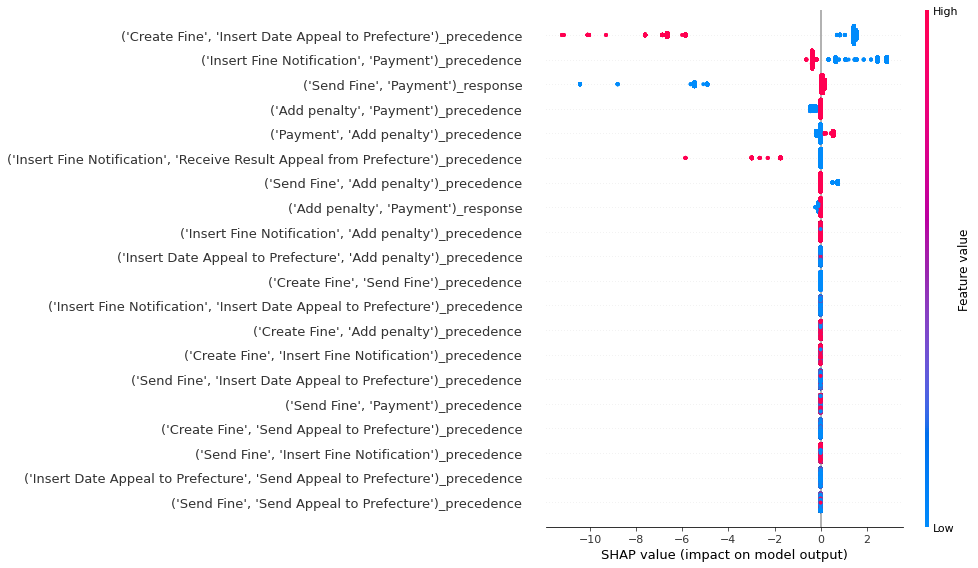

time: 4.74 s (started: 2022-03-17 11:28:11 +00:00)


In [ ]:
shap.summary_plot(shap_values, declare_df_boolean_non_zero)

In [ ]:
for col in declare_df_boolean_non_zero.columns: 
#     value_25 = declare_df_non_zero[col].describe()['25%']
#     value_75 = declare_df_non_zero[col].describe()['75%']
    
    shap.plots.partial_dependence(
        col , model.predict, declare_df_boolean_non_zero, ice=False,
        model_expected_value=True, feature_expected_value=True
    )

#     shap.plots.partial_dependence(
#         col , model.predict, declare_df_non_zero[(declare_df_non_zero[col]>=value_25)&(declare_df_non_zero[col]<=value_75)], ice=False,
#         model_expected_value=True, feature_expected_value=True
#     )

In [ ]:
declare_df_boolean_non_zero.iloc[4,:]

('T02 Check confirmation of receipt', 'T06 Determine necessity of stop advice')_precedence                 1
('Confirmation of receipt', 'T05 Print and send confirmation of receipt')_precedence                       1
('T02 Check confirmation of receipt', 'T05 Print and send confirmation of receipt')_precedence             1
('T04 Determine confirmation of receipt', 'T06 Determine necessity of stop advice')_precedence             1
('T10 Determine necessity to stop indication', 'T02 Check confirmation of receipt')_precedence             0
('Confirmation of receipt', 'T02 Check confirmation of receipt')_precedence                                1
('T02 Check confirmation of receipt', 'T10 Determine necessity to stop indication')_precedence             1
('T10 Determine necessity to stop indication', 'T04 Determine confirmation of receipt')_precedence         0
('T06 Determine necessity of stop advice', 'T10 Determine necessity to stop indication')_precedence        1
('T06 Determine nec

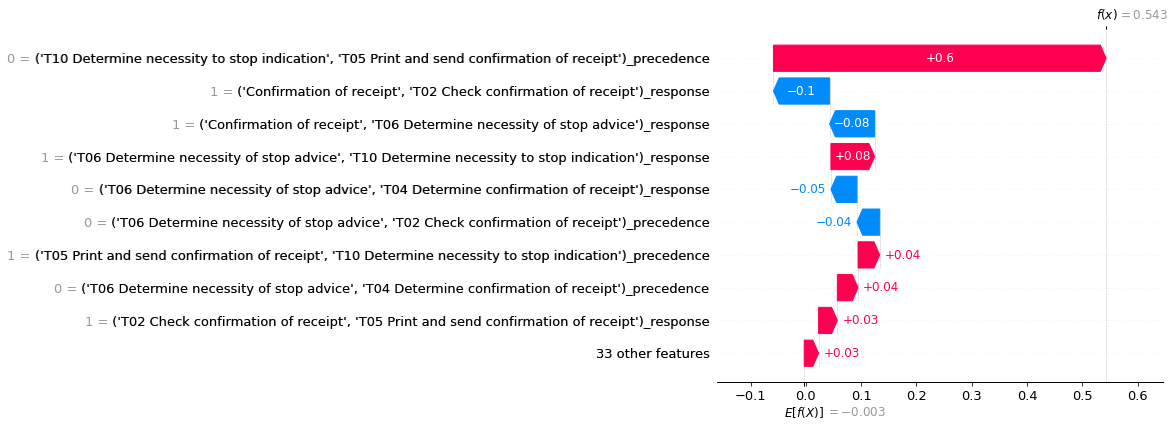

In [ ]:
shap.plots.waterfall(shap_values_obj[4])

In [ ]:
declare_df_boolean_non_zero.iloc[14,:]

('T02 Check confirmation of receipt', 'T06 Determine necessity of stop advice')_precedence                 1
('Confirmation of receipt', 'T05 Print and send confirmation of receipt')_precedence                       1
('T02 Check confirmation of receipt', 'T05 Print and send confirmation of receipt')_precedence             1
('T04 Determine confirmation of receipt', 'T06 Determine necessity of stop advice')_precedence             1
('T10 Determine necessity to stop indication', 'T02 Check confirmation of receipt')_precedence             0
('Confirmation of receipt', 'T02 Check confirmation of receipt')_precedence                                1
('T02 Check confirmation of receipt', 'T10 Determine necessity to stop indication')_precedence             1
('T10 Determine necessity to stop indication', 'T04 Determine confirmation of receipt')_precedence         0
('T06 Determine necessity of stop advice', 'T10 Determine necessity to stop indication')_precedence        1
('T06 Determine nec

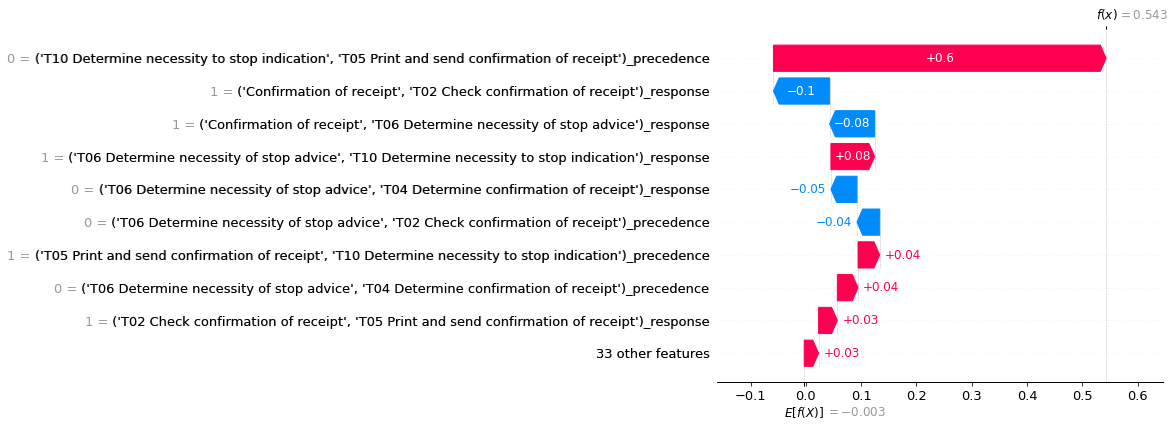

In [ ]:
shap.plots.waterfall(shap_values_obj[14])

In [ ]:
for col in declare_df_boolean_non_zero.columns:
    shap.dependence_plot(col, shap_values, declare_df_boolean_non_zero, interaction_index=None,alpha=0.1)

# **Evaluting Xbgoost model**

---



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(declare_df_boolean_non_zero, target, test_size=0.30, random_state=42)

time: 15.7 ms (started: 2022-03-24 10:53:47 +00:00)


In [ ]:
model_eval = XGBClassifier(use_label_encoder=False)
model_eval.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


XGBClassifier(use_label_encoder=False)

time: 1.69 s (started: 2022-03-24 10:53:47 +00:00)


In [ ]:
predictions = model_eval.predict(X_test)

time: 23.8 ms (started: 2022-03-24 10:53:49 +00:00)


In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()

time: 7.23 ms (started: 2022-03-24 10:53:53 +00:00)


In [ ]:
tn, fp, fn, tp

(1304, 71, 0, 6018)

time: 3.67 ms (started: 2022-03-24 10:53:54 +00:00)


In [ ]:
print(precision_score(y_test,predictions))

0.9883396288388898
time: 10.5 ms (started: 2022-03-24 10:53:54 +00:00)


In [ ]:
from sklearn.model_selection import cross_validate

time: 1.11 ms (started: 2022-03-24 10:53:57 +00:00)


In [ ]:
model_eval = XGBClassifier(use_label_encoder=False,n_jobs=-1)
scores = cross_validate(model_eval,
                        declare_df_boolean_non_zero,target,scoring=["roc_auc","precision","f1","neg_log_loss","average_precision"],
                        cv=4, 
                        n_jobs=-1)

time: 10.5 s (started: 2022-03-24 10:54:11 +00:00)


In [ ]:
scores

{'fit_time': array([4.68551874, 4.89384198, 5.09710503, 4.64020944]),
 'score_time': array([0.05703378, 0.18986511, 0.10519791, 0.11453676]),
 'test_average_precision': array([0.99427591, 0.99168127, 0.99451574, 0.99415451]),
 'test_f1': array([0.99622866, 0.99366462, 0.99682161, 0.99297517]),
 'test_neg_log_loss': array([-0.0359587 , -0.05224858, -0.03404854, -0.05642587]),
 'test_precision': array([0.99248566, 0.98740901, 0.99366337, 0.98604834]),
 'test_roc_auc': array([0.98747335, 0.98147059, 0.98787413, 0.98657608])}

time: 8.55 ms (started: 2022-03-24 10:54:33 +00:00)


In [ ]:
scores

In [ ]:
np.mean([4.68551874, 4.89384198, 5.09710503, 4.64020944])

4.8291687974999995

time: 4.9 ms (started: 2022-03-24 10:54:45 +00:00)


# SHAP values converting into percentage 

Concers to discuss with nawid 'why divide by the ratio'

In [ ]:
def shap_to_impact_percentage(shap_values:np.ndarray, declare_df_non_zero:pd.DataFrame,base_value)->pd.DataFrame:
    shap_df = pd.DataFrame(shap_values , columns=declare_df_non_zero.columns)
    
    shap_df['expected_output'] = np.round(shap_values.sum(axis=1)+base_value,2)
    
    shap_df['sig_expected_output'] = tf.math.sigmoid(shap_df['expected_output'])
    shap_df['probability'] = shap_df['sig_expected_output'] - tf.math.sigmoid(base_value)
    shap_df['probability'] = shap_df['probability']*100
    shap_df['dist'] = shap_df['expected_output'] - base_value
    shap_df_transformed = shap_df.iloc[:,:-4].div(shap_df.dist, axis=0)
    #  mult the ratio to the sigmoid dist
    shap_df_transformed = shap_df_transformed.loc[:,:].mul(shap_df.loc[:,'probability'],axis = 0)
    
    return shap_df_transformed

time: 9.52 ms (started: 2022-03-24 08:16:04 +00:00)


In [ ]:
def percetage_impact_per_value(declare_df_non_zero:pd.DataFrame,shap_df_transformed:pd.DataFrame, target:pd.DataFrame)->pd.DataFrame:
    ratio = (target.value_counts()[1]/target.shape[0])*100
    max_length = 0
    new_dict = {}
    shap_df_transformed = shap_df_transformed.loc[:, (shap_df_transformed != 0).any(axis=0)]
    population_size,_ = declare_df_non_zero.shape
    population_size_threshold = population_size*(1/100)
    for col in shap_df_transformed.columns:
        df1 = shap_df_transformed[col]
        df1 = df1.rename("shap")
        df2 = declare_df_non_zero[col]
        df2 = df2.rename("value")
        transformed_shap_value = pd.concat([df1, df2], axis=1)
        values_shap_trans = transformed_shap_value.groupby(['value'], as_index = False).agg({'shap':['mean', 'count']})
        values_shap_trans.columns = values_shap_trans.columns.droplevel(level=0)
        values_shap_trans.columns = ['value', 'mean', 'count']
        values_shap_trans['impact']= (values_shap_trans['mean']/ratio)*100
#         positive_impact = values_shap_trans[(values_shap_trans['impact']>0)& (values_shap_trans['count']>population_size_threshold)]
        positive_impact = values_shap_trans
        positive_impact_dict = positive_impact.to_dict()
        positive_impact_len , _ = positive_impact.shape
        
        if positive_impact_len > max_length:
            max_length = positive_impact_len
            
        for key, list_value in positive_impact_dict.items():
            list_value = list(positive_impact_dict[key].values())
            new_dict[(col,key)] = list_value
            
    for col_name , col_values in new_dict.items():
        if len(col_values) < max_length:
            for i in range(len(col_values),max_length):
                col_values.append(None) 
            new_dict[col_name] = col_values
            
    return pd.DataFrame(new_dict)
            

time: 34.1 ms (started: 2022-03-24 08:16:05 +00:00)


In [ ]:
def get_impact(declare_df_non_zero:pd.DataFrame,target:pd.DataFrame)->pd.DataFrame:
    model = XGBClassifier(use_label_encoder=False)
    model.fit(declare_df_non_zero, target)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(declare_df_non_zero)
    base_value = explainer.expected_value
    shap_df_transformed = shap_to_impact_percentage(shap_values,declare_df_non_zero,base_value)
    return percetage_impact_per_value(declare_df_non_zero,shap_df_transformed, target)
    

time: 10.2 ms (started: 2022-03-24 08:16:05 +00:00)


In [ ]:
def remove_reduntant(filtered_positive_constraints: list)->list:
    final_positive = list()
    
    for rule in filtered_positive_constraints:
        tuple_str = rule.split("_")[0]
        relation_name = rule.split("_")[-1]
        events = tuple_str.split(", ")
        event_e = events[0].split("'")[1]
        event_f = events[1].split("'")[1]
        reverse = get_col_name(event_f,event_e, relation_name)

        if reverse in filtered_positive_constraints:
            item_e_sort, item_f_sort = tuple(sorted((event_e,event_f)))
            alternate_succession = get_col_name(item_e_sort,item_f_sort, 'alternate_succession')
            if alternate_succession in filtered_positive_constraints:
                final_positive.append(alternate_succession)
        else:
            final_positive.append(rule)

    final_positive = list(set(final_positive))
    
    return final_positive      

time: 18.7 ms (started: 2022-03-24 08:16:06 +00:00)


In [ ]:
def confident_positive_constraints(filtered_positive_constraints:list, positive_impact_df:pd.DataFrame)->list:
    confident = list()
    
    for constraint in list(set(positive_impact_df.columns.get_level_values(0))):
        value_one_count = positive_impact_df.loc[1,(constraint,'count')]
        value_zero_count = positive_impact_df.loc[0,(constraint,'count')]
        if value_one_count > (value_one_count+value_zero_count)*0.3:
            confident.append(constraint)
            
    return confident

time: 7.16 ms (started: 2022-03-24 08:16:07 +00:00)


In [ ]:
def filter_positive_based_on_reality(positive_impact_cols:list, declare_df_boolean_non_zero:pd.DataFrame, target:pd.DataFrame)->list:
  filtered_constraints = list()
  for constraint in positive_impact_cols:
    constraint_indx = declare_df_boolean_non_zero[declare_df_boolean_non_zero[constraint]==1].index
    true_rate_when_constraint = (sum(target.iloc[constraint_indx,0])/len(constraint_indx))*100

    constraint_indx = declare_df_boolean_non_zero[declare_df_boolean_non_zero[constraint]==0].index
    true_rate_when_no_constraint = (sum(target.iloc[constraint_indx,0])/len(constraint_indx))*100
    if true_rate_when_constraint > true_rate_when_no_constraint:
      filtered_constraints.append(constraint)
  return filtered_constraints

time: 6.33 ms (started: 2022-03-24 08:16:08 +00:00)


In [ ]:
def get_positive_impact(all_impact_constraints:pd.DataFrame,declare_df_non_zero:pd.DataFrame,target:pd.DataFrame)->pd.DataFrame:
    filtered_positive_constraints = list()
    for constraint in list(set(all_impact_constraints.columns.get_level_values(0))):
        value_one_impact = all_impact_constraints.loc[1,(constraint,'impact')]
        value_zero_impact = all_impact_constraints.loc[0,(constraint,'impact')]
        if value_one_impact > 0:
            if value_zero_impact<0 :
                filtered_positive_constraints.append(constraint)
                
    positive_imapct = all_impact_constraints.iloc[:, all_impact_constraints.columns.get_level_values(0).isin(filtered_positive_constraints)]
                
    filtered_positive_constraints = confident_positive_constraints(filtered_positive_constraints,positive_imapct)

    filtered_positive_constraints = filter_positive_based_on_reality(filtered_positive_constraints, declare_df_boolean_non_zero, target)
    
    filtered_positive_constraints = remove_reduntant(filtered_positive_constraints)

    return all_impact_constraints.iloc[:, all_impact_constraints.columns.get_level_values(0).isin(filtered_positive_constraints)]



time: 10.9 ms (started: 2022-03-24 08:16:09 +00:00)


In [ ]:
def confident_negative_constraints(filtered_negative_constraints:list,negative_impact_df:pd.DataFrame)->list:
    confident = list()
    
    for constraint in list(set(negative_impact_df.columns.get_level_values(0))):
        value_one_count = negative_impact_df.loc[1,(constraint,'count')]
        value_zero_count = negative_impact_df.loc[0,(constraint,'count')]
        if value_zero_count > (value_one_count+value_zero_count)*0.3 :
            confident.append(constraint)
            
    return confident

time: 4.17 ms (started: 2022-03-24 08:16:10 +00:00)


In [ ]:
def filter_negative_based_on_reality(negative_impact_cols:list, declare_df_boolean_non_zero:pd.DataFrame, target:pd.DataFrame)->list:
  filtered_constraints = list()
  for constraint in negative_impact_cols:
    constraint_indx = declare_df_boolean_non_zero[declare_df_boolean_non_zero[constraint]==0].index
    true_rate_when_no_constraint = (sum(target.iloc[constraint_indx,0])/len(constraint_indx))*100
    constraint_indx = declare_df_boolean_non_zero[declare_df_boolean_non_zero[constraint]==1].index
    true_rate_when_constraint = (sum(target.iloc[constraint_indx,0])/len(constraint_indx))*100
    if true_rate_when_no_constraint > true_rate_when_constraint:
      filtered_constraints.append(constraint)
  return filtered_constraints

time: 9 ms (started: 2022-03-24 08:16:11 +00:00)


In [ ]:
def get_negative_impact(all_impact_constraints:pd.DataFrame,declare_df_non_zero:pd.DataFrame,target:pd.DataFrame)->pd.DataFrame:
    filtered_negative_constraints = list()
    for constraint in list(set(all_impact_constraints.columns.get_level_values(0))):
        value_one_impact = all_impact_constraints.loc[1,(constraint,'impact')]
        value_zero_impact = all_impact_constraints.loc[0,(constraint,'impact')]
        if value_one_impact <0:
            if value_zero_impact >0 :
                filtered_negative_constraints.append(constraint)
                
    negative_imapct = all_impact_constraints.iloc[:, all_impact_constraints.columns.get_level_values(0).isin(filtered_negative_constraints)]
                
    filtered_negative_constraints = confident_negative_constraints(filtered_negative_constraints,negative_imapct)

    filtered_negative_constraints = filter_negative_based_on_reality(filtered_negative_constraints, declare_df_boolean_non_zero, target)

    filtered_negative_constraints = remove_reduntant(filtered_negative_constraints)

    return all_impact_constraints.iloc[:, all_impact_constraints.columns.get_level_values(0).isin(filtered_negative_constraints)]



time: 17.4 ms (started: 2022-03-24 08:16:12 +00:00)


In [ ]:

pd.options.display.max_columns = None
all_impact_constraints = get_impact(declare_df_boolean_non_zero,target)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


time: 3.61 s (started: 2022-03-24 08:16:13 +00:00)


In [ ]:
all_impact_constraints

('Send Fine', 'Add penalty')_precedence                             \
                                    value      mean  count    impact   
0                                       0  0.926632   3379  1.137448   
1                                       1 -0.020403  21262 -0.025045   

  ('Create Fine', 'Insert Date Appeal to Prefecture')_precedence             \
                                                           value       mean   
0                                                  0               3.132419   
1                                                  1             -60.412766   

                    ('Add penalty', 'Payment')_precedence                   \
   count     impact                                 value      mean  count   
0  20453   3.845070                                     0 -1.185850  10542   
1   4188 -74.157166                                     1  0.013275  14099   

            ('Insert Fine Notification', 'Payment')_precedence            \
     impact                                              value      mean   
0 -1.455640                                                  0  3.566710   
1  0.016296                                                  1 -1.014971   

                   ('Payment', 'Add penalty')_precedence                   \
   count    impact                                 value      mean  count   
0  10528  4.378165                                     0 -0.147420  21121   
1  14113 -1.245886                                     1  0.541047   3520   

            ('Send Fine', 'Payment')_response                               \
     impact                             value       mean  count     impact   
0 -0.180959                                 0 -44.431187   3792 -54.539646   
1  0.664139                                 1   0.210260  20849   0.258095   

  ('Add penalty', 'Payment')_response                             
                                value      mean  count    impact  
0                                   0 -0.487516   7036 -0.598429  
1                                   1  0.003786  17605  0.004647

time: 119 ms (started: 2022-03-24 08:16:16 +00:00)


In [ ]:
positive_impact = get_positive_impact(all_impact_constraints,declare_df_boolean_non_zero,target)

time: 91.3 ms (started: 2022-03-24 08:16:17 +00:00)


In [ ]:
negative_impact = get_negative_impact(all_impact_constraints,declare_df_boolean_non_zero,target)

time: 25.3 ms (started: 2022-03-24 08:16:18 +00:00)


In [ ]:
positive_impact

('Add penalty', 'Payment')_precedence                             \
                                  value      mean  count    impact   
0                                     0 -1.185850  10542 -1.455640   
1                                     1  0.013275  14099  0.016296   

  ('Send Fine', 'Payment')_response                               \
                              value       mean  count     impact   
0                                 0 -44.431187   3792 -54.539646   
1                                 1   0.210260  20849   0.258095   

  ('Add penalty', 'Payment')_response                             
                                value      mean  count    impact  
0                                   0 -0.487516   7036 -0.598429  
1                                   1  0.003786  17605  0.004647

time: 18.2 ms (started: 2022-03-24 08:16:20 +00:00)


In [ ]:
negative_impact

('Create Fine', 'Insert Date Appeal to Prefecture')_precedence             \
                                                           value       mean   
0                                                  0               3.132419   
1                                                  1             -60.412766   

                     
   count     impact  
0  20453   3.845070  
1   4188 -74.157166

time: 9.89 ms (started: 2022-03-24 08:16:21 +00:00)


In [ ]:
for constraint in list(set(positive_impact.columns.get_level_values(0))):
    print(constraint)
    constraint_indx = declare_df_boolean_non_zero[declare_df_boolean_non_zero[constraint]==1].index
    print((sum(target.iloc[constraint_indx,0])/len(constraint_indx))*100)
    constraint_indx = declare_df_boolean_non_zero[declare_df_boolean_non_zero[constraint]==0].index
    print((sum(target.iloc[constraint_indx,0])/len(constraint_indx))*100)
    print(len(constraint_indx))



('Add penalty', 'Payment')_response
95.71712581652939
45.807276861853325
7036
('Add penalty', 'Payment')_precedence
94.70884459890773
63.7545057863783
10542
('Send Fine', 'Payment')_response
96.2827953379059
0.0
3792
time: 35.2 ms (started: 2022-03-24 08:17:24 +00:00)


In [ ]:
negative_impact

('Create Fine', 'Insert Date Appeal to Prefecture')_precedence             \
                                                           value       mean   
0                                                  0               3.132419   
1                                                  1             -60.412766   

                     
   count     impact  
0  20453   3.845070  
1   4188 -74.157166

time: 13.6 ms (started: 2022-03-24 08:17:57 +00:00)


In [ ]:
for constraint in list(set(negative_impact.columns.get_level_values(0))):
    print(constraint)
    constraint_indx = declare_df_boolean_non_zero[declare_df_boolean_non_zero[constraint]==0].index
    print((sum(target.iloc[constraint_indx,0])/len(constraint_indx))*100)
    constraint_indx = declare_df_boolean_non_zero[declare_df_boolean_non_zero[constraint]==1].index
    print((sum(target.iloc[constraint_indx,0])/len(constraint_indx))*100)
    print(len(constraint_indx))


('Create Fine', 'Insert Date Appeal to Prefecture')_precedence
98.14697110448346
0.0
4188
time: 17.5 ms (started: 2022-03-24 08:17:59 +00:00)
